In [84]:
## Libraries
import json
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings


# pd options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# suppress warning message
warnings.simplefilter(action='ignore', category=UserWarning)

In [88]:
## Read in JSON file
with open("raw.json", "r", encoding="utf-8") as file:
    raw_json_str = file.read()

# Remove problematic characters
clean_json_str = re.sub(r"[\x00-\x1F]+", " ", raw_json_str)

#function to flatten the JSON structure
def flatten_json(node, account_type=None, category=None):
    flattened = []
    if isinstance(node, dict):
        if 'name' in node and 'value' in node:
            flattened.append({
                'account_type': account_type,  
                'category': category, 
                'account_id': node.get('account_id'),
                'name': node.get('name'),
                'value': node.get('value')
            })
        if 'items' in node:
            for item in node['items']:
                flattened.extend(flatten_json(item, category=node.get('name'), account_type=account_type))
    elif isinstance(node, list):
        for item in node:
            flattened.extend(flatten_json(item, category=category, account_type=account_type))
    return flattened

# Extract and row bind to a data frame
all_rows = []
for section in ['assets', 'liabilities', 'equity']:
    if section in data:
        sec_data = data[section]
        all_rows.append({
            'account_type': section, 
            'category': None, 
            'account_id': None,
            'name': sec_data.get('name'),
            'value': sec_data.get('value')
        })
        all_rows.extend(flatten_json(sec_data.get('items', []), category=sec_data.get('name'), account_type=section))

# Convert to Pandas DataFrame
df = pd.DataFrame(all_rows)

df.head()

,account_type,category,account_id,name,value
0,assets,None,None,ASSETS,13318970.87
1,assets,ASSETS,None,Current Assets,13300233.24
2,assets,Current Assets,None,Bank Accounts,-513160.89
3,assets,Bank Accounts,6c9790a2-0800-46cc-8c50-e29e69d8015c,Flex Cash,806291.61
4,assets,Bank Accounts,b58e60f6-fe20-451e-9fc2-87eb58bcb297,Flex Checking,-1272375.00


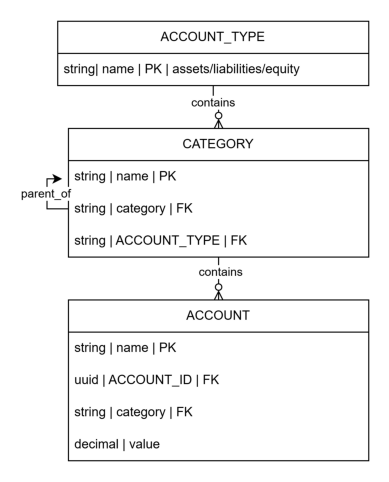

In [37]:
## read in and show ERD 
img = mpimg.imread("ERD.png")
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis("off")  # Hide axis
plt.show()


In [76]:
## Function to validate roll-ups based on the parent and child node
def validate_rollups(df):
    discrepancies = []

    # Sum up parent node account_type
    rollup_sums = df.groupby("account_type")["value"].sum().to_dict()

    # Iterate over unique account_types (parents) and compare expected vs. calculated sum
    for parent in df["account_type"].dropna().unique():
        expected_value = df.loc[df["account_type"] == parent, "value"].sum()
        calculated_sum = df.loc[(df["account_type"] == parent) & (~df["category"].isna()), "value"].sum()

        # Check if there's a discrepancy
        if round(expected_value, 2) != round(calculated_sum, 2):
            discrepancies.append({
                "Parent": parent,
                "Expected Value": expected_value,
                "Calculated Sum": calculated_sum,
                "Discrepancy": calculated_sum - expected_value  # Fixed discrepancy calculation
            })

    return discrepancies

# Apply validation
discrepancies = pd.DataFrame(validate_rollups(df))

discrepancies

,Parent,Expected Value,Calculated Sum,Discrepancy
0,assets,53275883.48,39956912.61,-13318970.87
1,liabilities,4873108.17,3848091.18,-1025016.99
2,equity,24703203.10,12304101.55,-12399101.55


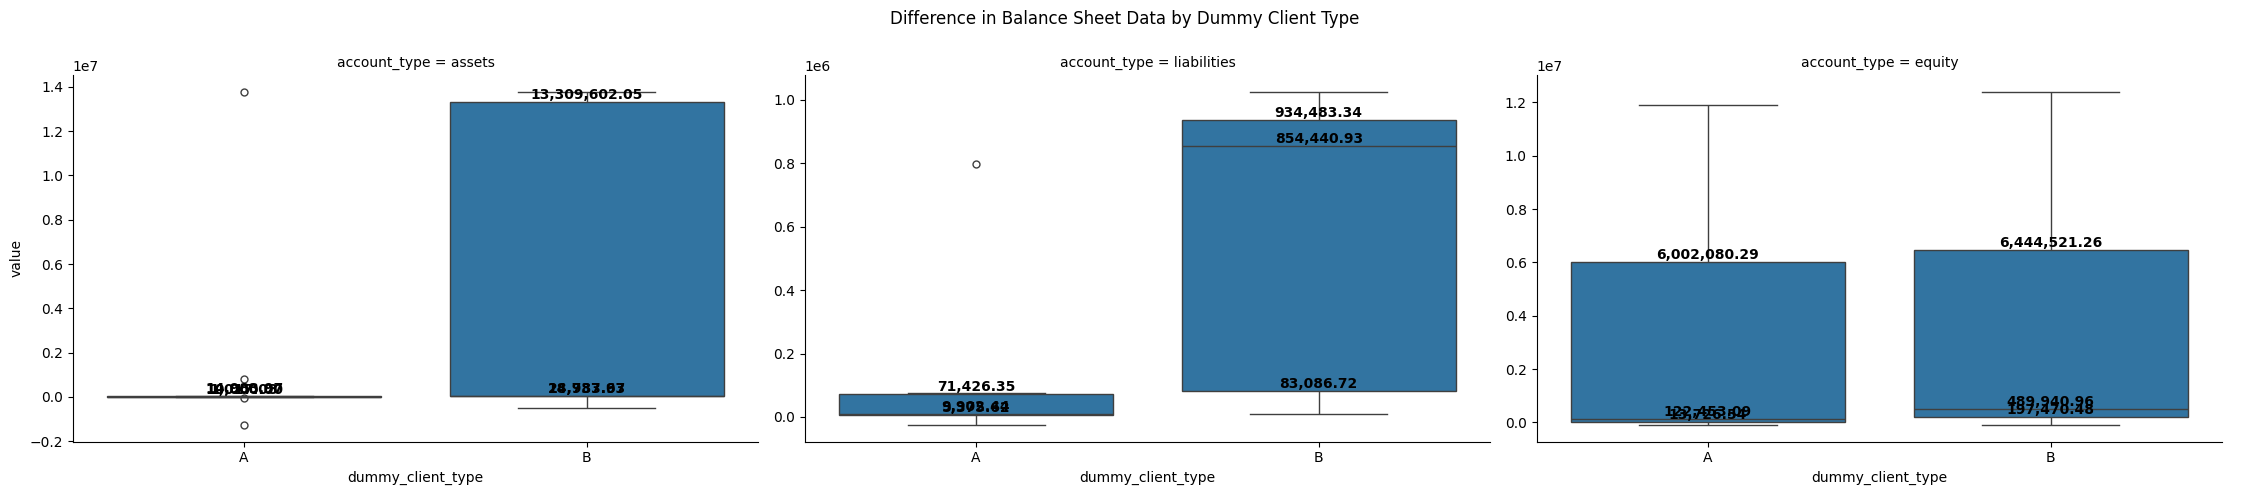

In [99]:
## Bonus Analysis - Data visualixation

# Distribution of Asset, Liability, Equity 
# Create a dummy variable for client type to identify difference in balance sheet by client group.
df_viz = df.copy()

# Create dummy_client_type based on account_id 
df_viz["dummy_client_type"] = df_viz["account_id"].notnull().astype(int).replace({1: "A", 0: "B"})
df_viz["dummy_client_type"] = df_viz["dummy_client_type"].astype("category")
df_viz["value"] = pd.to_numeric(df_viz["value"], errors="coerce")

# Create the whisker plot
g = sns.catplot(
    data=df_viz,
    x="dummy_client_type",
    y="value",
    col="account_type",
    kind="box",
    height=5,
    aspect=1.5,
    col_wrap=3,
    sharex=True, 
    sharey=False
)

# Add percentile labels (25th, 50th, 75th) to each box plot
for ax, account_type in zip(g.axes.flat, df_viz["account_type"].unique()):
    subset = df_viz[df_viz["account_type"] == account_type]
    for i, dummy_type in enumerate(subset["dummy_client_type"].cat.categories):
        sub_subset = subset[subset["dummy_client_type"] == dummy_type]["value"].dropna()
        if not sub_subset.empty:
            q25, q50, q75 = sub_subset.quantile([0.25, 0.50, 0.75])
            ax.text(i, q25, f"{q25:,.2f}", ha="center", va="bottom", fontsize=10, color="black", fontweight="bold")
            ax.text(i, q50, f"{q50:,.2f}", ha="center", va="bottom", fontsize=10, color="black", fontweight="bold")  # Median in red
            ax.text(i, q75, f"{q75:,.2f}", ha="center", va="bottom", fontsize=10, color="black", fontweight="bold")

# Adjust title and layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Difference in Balance Sheet Data by Dummy Client Type")

plt.show()
